# S&P 500 Forecasting Project - GARCH Modeling

This notebook implements GARCH models to capture volatility patterns in S&P 500 returns. We'll explore different model specifications, evaluate their performance, and generate forecasts for the target period.

## 1. Import Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import arch
from arch import arch_model
import sys
import os

# Add the src directory to the Python path
sys.path.append(os.path.abspath('../'))

# Import project modules
from src.data_utils import load_sp500_data, calculate_returns, calculate_evaluation_metrics
from src.garch_model import (find_optimal_garch_params, train_garch_model,
                           forecast_garch, convert_returns_to_price,
                           plot_garch_volatility, plot_garch_forecast)

# Set plot style
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 12

# Set pandas display options
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 1000)

## 2. Load Processed Data

In [2]:
# Load the preprocessed data
data_path = '../data/processed/sp500_processed.csv'
train_path = '../data/processed/sp500_train.csv'
test_path = '../data/processed/sp500_test.csv'

# Check if processed data exists
if os.path.exists(data_path) and os.path.exists(train_path) and os.path.exists(test_path):
    # Load from processed files
    sp500_data = pd.read_csv(data_path, index_col=0, parse_dates=True)
    train_data = pd.read_csv(train_path, index_col=0, parse_dates=True)
    test_data = pd.read_csv(test_path, index_col=0, parse_dates=True)
else:
    # If processed data doesn't exist, load raw data and process it
    raw_data_path = '../data/HistoricalData_1740743587727.csv'
    sp500_data = load_sp500_data(raw_data_path)
    
    # Calculate returns
    sp500_data = calculate_returns(sp500_data)
    
    # Split into training and testing sets
    forecast_dates = pd.date_range(start='2025-02-24', end='2025-02-28', freq='B')
    mask = sp500_data.index.isin(forecast_dates)
    train_data = sp500_data[~mask].copy()
    test_data = sp500_data[mask].copy()

print(f"Data shape: {sp500_data.shape}")
print(f"Training data shape: {train_data.shape}")
print(f"Testing data shape: {test_data.shape}")

Data shape: (2521, 7)
Training data shape: (2516, 7)
Testing data shape: (5, 7)


In [3]:
# Check if returns are already calculated
if 'Returns' not in train_data.columns:
    train_data = calculate_returns(train_data)
    test_data = calculate_returns(test_data)

# Display the returns for the last few days
print("Returns for the last 5 days of training data:")
train_data[['Close/Last', 'Returns']].tail()

Returns for the last 5 days of training data:


,Close/Last,Returns
Date,,
2025-02-13,6115.07,1.042636
2025-02-14,6114.63,-0.007195
2025-02-18,6129.58,0.244496
2025-02-19,6144.15,0.237700
2025-02-20,6117.52,-0.433420


## 3. Analyze Volatility Clustering

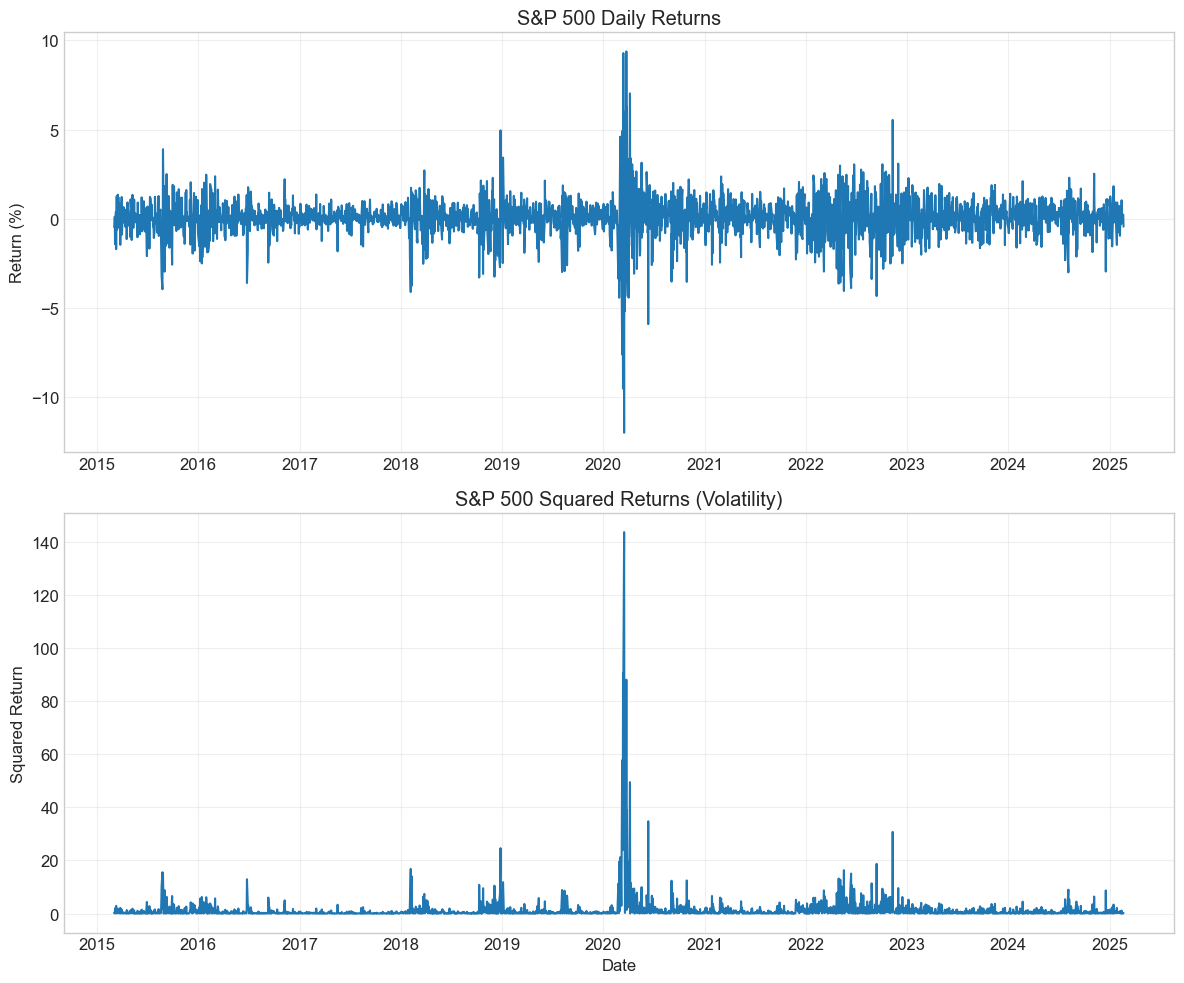

In [4]:
# Calculate squared returns as a proxy for volatility
train_data['Returns_Squared'] = train_data['Returns'] ** 2

# Plot returns and squared returns
fig, axes = plt.subplots(2, 1, figsize=(12, 10))

# Plot returns
axes[0].plot(train_data.index, train_data['Returns'])
axes[0].set_title('S&P 500 Daily Returns')
axes[0].set_ylabel('Return (%)')
axes[0].grid(True, alpha=0.3)

# Plot squared returns
axes[1].plot(train_data.index, train_data['Returns_Squared'])
axes[1].set_title('S&P 500 Squared Returns (Volatility)')
axes[1].set_xlabel('Date')
axes[1].set_ylabel('Squared Return')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()

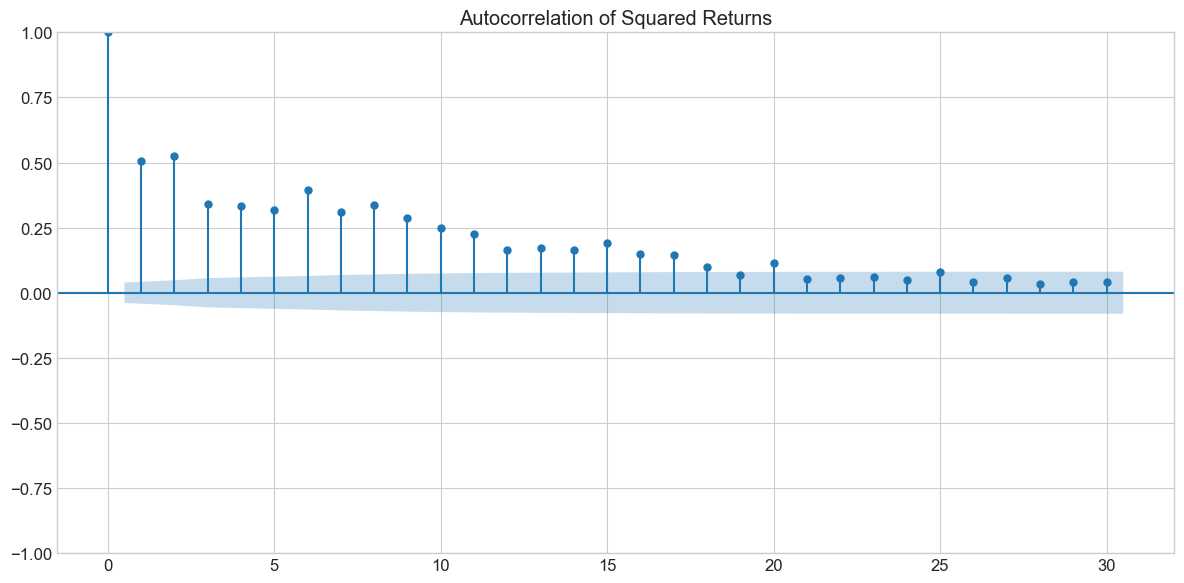

In [5]:
# Check autocorrelation in squared returns
from statsmodels.graphics.tsaplots import plot_acf

fig, ax = plt.subplots(figsize=(12, 6))
plot_acf(train_data['Returns_Squared'].dropna(), lags=30, ax=ax)
ax.set_title('Autocorrelation of Squared Returns')
plt.tight_layout()

In [6]:
# Test for ARCH effects using Engle's ARCH test
from statsmodels.stats.diagnostic import het_arch

arch_test = het_arch(train_data['Returns'].dropna(), nlags=10)

print("Engle's ARCH Test:")
print(f"Lagrange multiplier statistic: {arch_test[0]}")
print(f"p-value: {arch_test[1]}")
print(f"F-statistic: {arch_test[2]}")
print(f"p-value (F): {arch_test[3]}")

if arch_test[1] < 0.05:
    print("Conclusion: ARCH effects are present in the returns series (reject the null hypothesis of no ARCH effects)")
else:
    print("Conclusion: No significant ARCH effects detected (fail to reject the null hypothesis)")

Engle's ARCH Test:
Lagrange multiplier statistic: 988.7590411390552
p-value: 4.934621537210507e-206
F-statistic: 162.63675204060746
p-value (F): 3.1530967181016465e-263
Conclusion: ARCH effects are present in the returns series (reject the null hypothesis of no ARCH effects)


## 4. Find Optimal GARCH Parameters

In [7]:
# Find optimal GARCH parameters
print("Finding optimal GARCH parameters...")
garch_results = find_optimal_garch_params(
    train_data['Returns'].dropna(),
    p_range=[1, 2],
    q_range=[1, 2],
    power_range=[2.0],
    distribution='normal'
)

print(f"\nOptimal GARCH parameters: p={garch_results['p']}, q={garch_results['q']}, power={garch_results['power']}")
print(f"AIC: {garch_results['aic']:.4f}")
print(f"BIC: {garch_results['bic']:.4f}")

Finding optimal GARCH parameters...

Optimal GARCH parameters: p=1, q=1, power=2.0
AIC: 6451.6102
BIC: 6474.9303


## 5. Train GARCH Model

In [8]:
# Train GARCH model with optimal parameters
garch_model = train_garch_model(
    train_data['Returns'].dropna(),
    p=garch_results['p'],
    q=garch_results['q'],
    mean='AR',
    lags=1,
    vol='GARCH',
    power=garch_results['power'],
    dist='normal'
)

# Display model summary
print(garch_model['result'].summary())

                           AR - GARCH Model Results                           
Dep. Variable:                Returns   R-squared:                       0.011
Mean Model:                        AR   Adj. R-squared:                  0.010
Vol Model:                      GARCH   Log-Likelihood:               -3217.90
Distribution:                  Normal   AIC:                           6445.79
Method:            Maximum Likelihood   BIC:                           6474.94
                                        No. Observations:                 2514
Date:                Mon, Mar 17 2025   Df Residuals:                     2512
Time:                        12:24:59   Df Model:                            2
                                  Mean Model                                  
                 coef    std err          t      P>|t|        95.0% Conf. Int.
------------------------------------------------------------------------------
Const          0.0868  1.520e-02      5.710  1.132e-

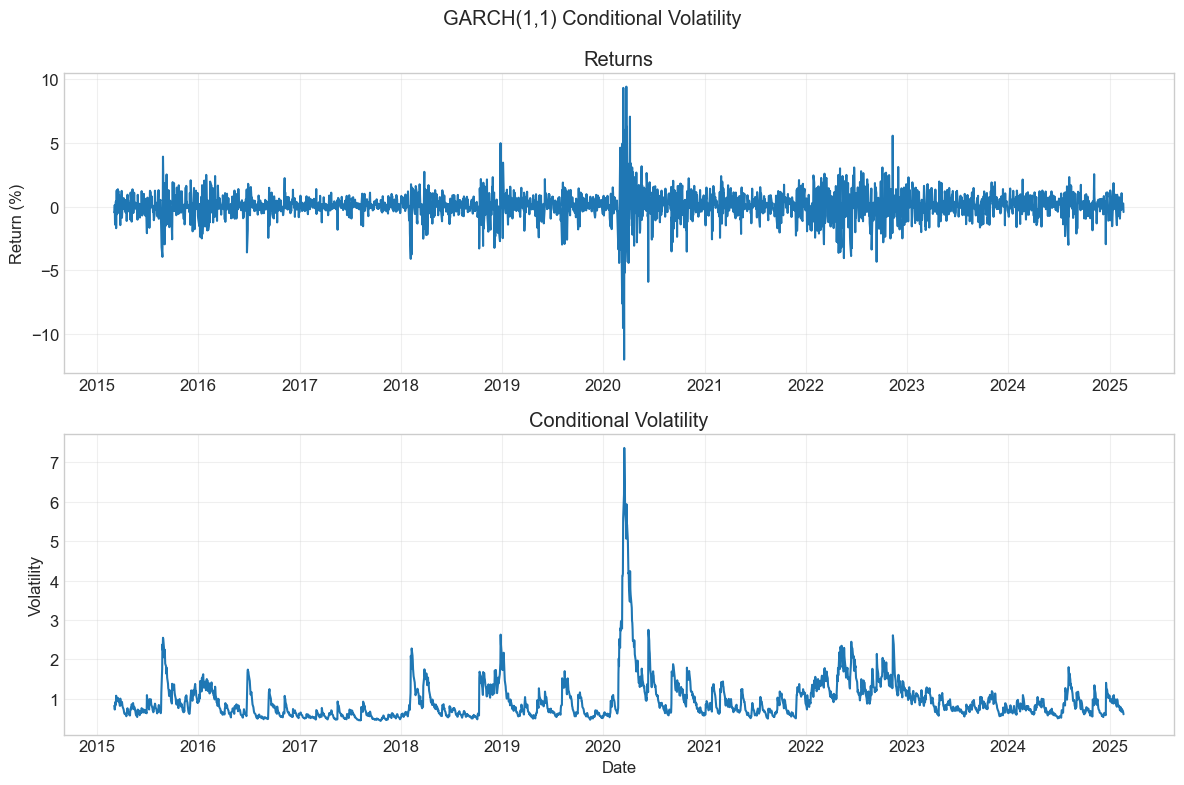

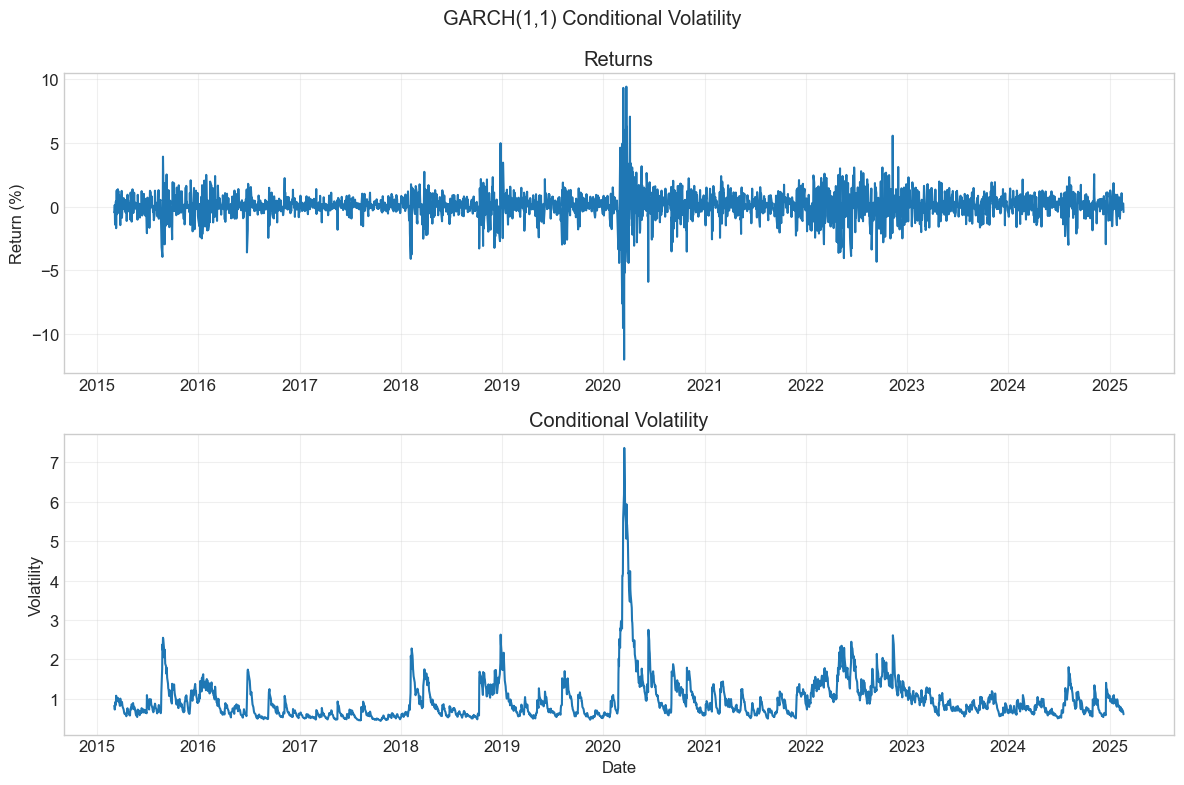

In [9]:
# Plot conditional volatility
plot_garch_volatility(
    train_data['Returns'].dropna(),
    garch_model['result'],
    title=f'GARCH({garch_results["p"]},{garch_results["q"]}) Conditional Volatility'
)

## 6. Generate Forecasts

In [10]:
# Generate forecasts for the test period
forecast_horizon = len(test_data)
forecast_results = forecast_garch(
    garch_model['result'],
    horizon=forecast_horizon,
    reindex=test_data.index
)

# Display forecasts
print("GARCH Forecasts (Returns):")
forecast_df = pd.DataFrame({
    'Actual Returns': test_data['Returns'],
    'Forecast Returns': forecast_results['mean_forecast'],
    'Forecast Volatility': forecast_results['volatility_forecast']
})
forecast_df

GARCH Forecasts (Returns):


/Users/OlavNikolai/TIO4317_project/venv/lib/python3.11/site-packages/arch/__future__/_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(


,Actual Returns,Forecast Returns,Forecast Volatility
Date,,,
2025-02-21,-1.706410,0.109766,0.615783
2025-02-24,-0.496913,0.080956,0.637464
2025-02-25,-0.467973,0.082484,0.657077
2025-02-26,0.013601,0.082403,0.675550
2025-02-27,-1.586451,0.082407,0.692993


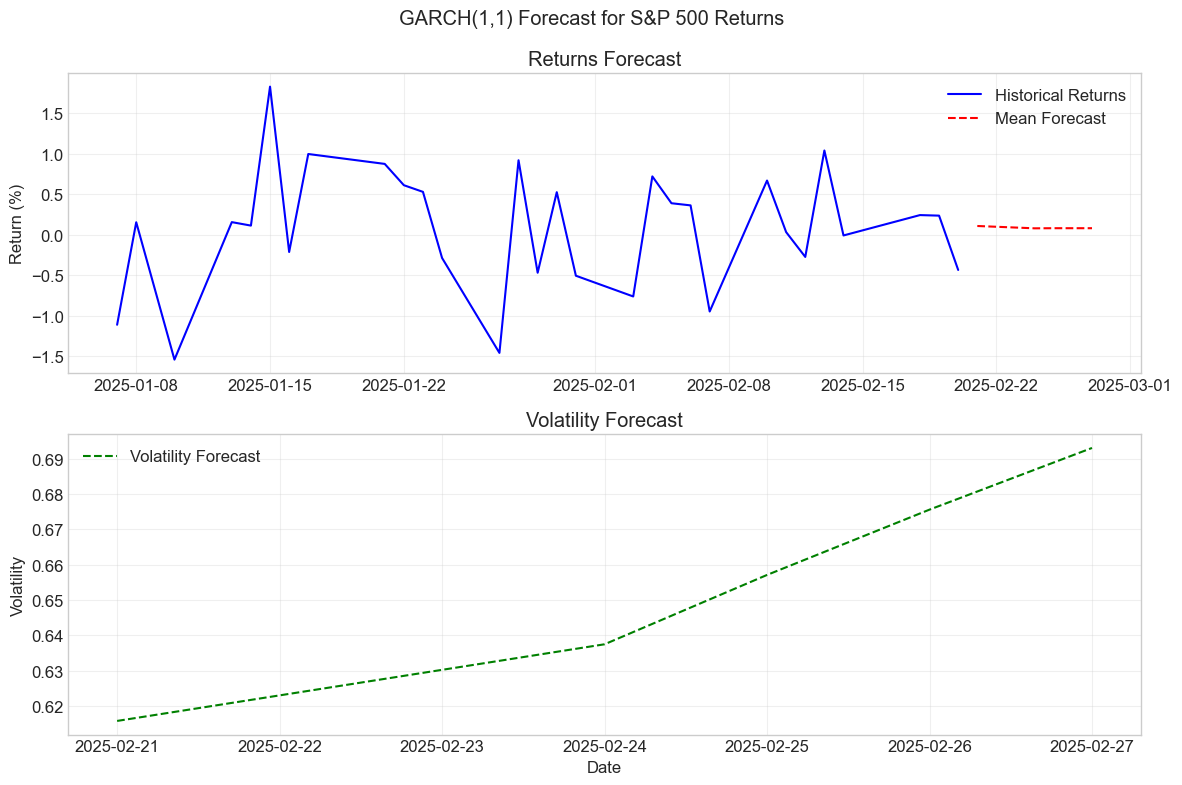

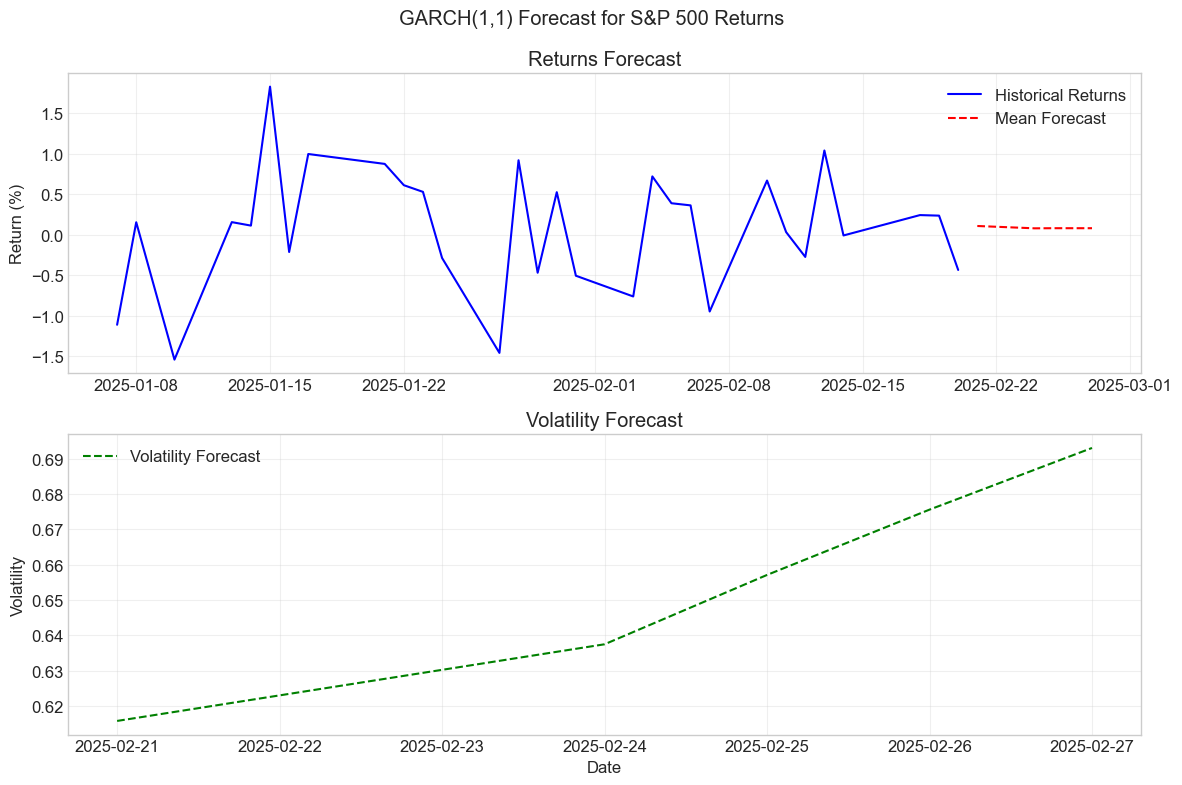

In [11]:
# Plot forecasts
plot_garch_forecast(
    train_data['Returns'].dropna().iloc[-30:],
    forecast_results,
    title=f'GARCH({garch_results["p"]},{garch_results["q"]}) Forecast for S&P 500 Returns'
)

## 7. Convert Returns Forecasts to Price Forecasts

In [12]:
# Get the last closing price from the training data
last_price = train_data['Close/Last'].iloc[-1]
print(f"Last closing price in training data: {last_price:.2f}")

# Convert returns forecasts to price forecasts
price_forecast = convert_returns_to_price(last_price, forecast_results['mean_forecast'])

# Display price forecasts
print("\nGARCH Price Forecasts:")
price_forecast_df = pd.DataFrame({
    'Date': test_data.index,
    'Actual': test_data['Close/Last'],
    'Forecast': price_forecast
})
price_forecast_df

Last closing price in training data: 6117.52

GARCH Price Forecasts:


,Date,Actual,Forecast
Date,,,
2025-02-21,2025-02-21,6013.13,6124.234937
2025-02-24,2025-02-24,5983.25,6129.192855
2025-02-25,2025-02-25,5955.25,6134.248443
2025-02-26,2025-02-26,5956.06,6139.303230
2025-02-27,2025-02-27,5861.57,6144.362446


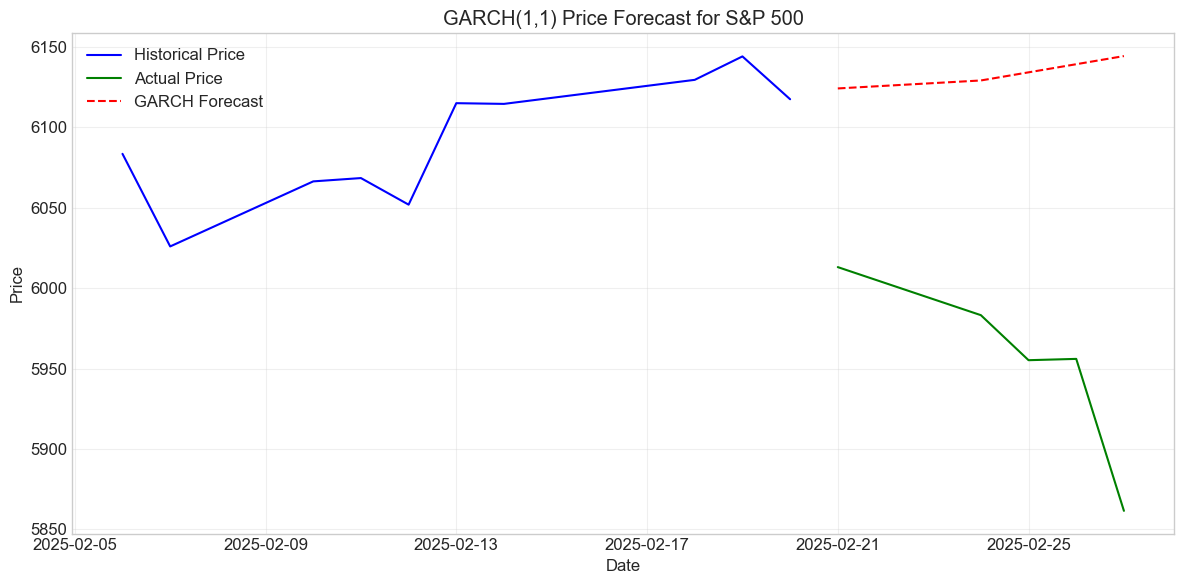

In [13]:
# Plot price forecasts
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(train_data.index[-10:], train_data['Close/Last'].iloc[-10:], 'b-', label='Historical Price')
ax.plot(test_data.index, test_data['Close/Last'], 'g-', label='Actual Price')
ax.plot(price_forecast.index, price_forecast, 'r--', label='GARCH Forecast')
ax.set_title(f'GARCH({garch_results["p"]},{garch_results["q"]}) Price Forecast for S&P 500')
ax.set_xlabel('Date')
ax.set_ylabel('Price')
ax.legend()
ax.grid(True, alpha=0.3)
plt.tight_layout()

## 8. Evaluate Forecast Accuracy

In [14]:
# Calculate evaluation metrics for price forecasts
actual_prices = test_data['Close/Last'].values
predicted_prices = price_forecast.values

price_metrics = calculate_evaluation_metrics(actual_prices, predicted_prices)

print("Price Forecast Evaluation Metrics:")
for metric, value in price_metrics.items():
    print(f"{metric}: {value:.4f}")

Price Forecast Evaluation Metrics:
MSE: 35846.7430
RMSE: 189.3324
R²: -12.8931
MAPE: 3.0387


In [15]:
# Calculate forecast error
price_forecast_df['Error'] = price_forecast_df['Actual'] - price_forecast_df['Forecast']
price_forecast_df['Percentage Error'] = (price_forecast_df['Error'] / price_forecast_df['Actual']) * 100

print("Price Forecast Errors:")
price_forecast_df[['Actual', 'Forecast', 'Error', 'Percentage Error']]

Price Forecast Errors:


,Actual,Forecast,Error,Percentage Error
Date,,,,
2025-02-21,6013.13,6124.234937,-111.104937,-1.847706
2025-02-24,5983.25,6129.192855,-145.942855,-2.439190
2025-02-25,5955.25,6134.248443,-178.998443,-3.005725
2025-02-26,5956.06,6139.303230,-183.243230,-3.076585
2025-02-27,5861.57,6144.362446,-282.792446,-4.824517


## 9. Try Alternative GARCH Specifications

In [16]:
# Define alternative GARCH specifications to try
alternative_specs = [
    {'p': 1, 'q': 1, 'mean': 'Constant', 'dist': 'normal'},  # Simple GARCH(1,1) with constant mean
    {'p': 1, 'q': 1, 'mean': 'AR', 'lags': 2, 'dist': 'normal'},  # GARCH(1,1) with AR(2) mean
    {'p': 1, 'q': 1, 'mean': 'AR', 'lags': 1, 'dist': 'studentst'},  # GARCH(1,1) with t-distribution
    {'p': 2, 'q': 2, 'mean': 'AR', 'lags': 1, 'dist': 'normal'}  # GARCH(2,2) with AR(1) mean
]

# Initialize list to store models and their metrics
garch_models = []

# Loop through the alternative specifications
for spec in alternative_specs:
    try:
        spec_name = f"GARCH({spec['p']},{spec['q']}) - {spec['mean']} - {spec['dist']}"
        print(f"Training {spec_name}...")
        
        # Train model
        model_result = train_garch_model(
            train_data['Returns'].dropna(),
            p=spec['p'],
            q=spec['q'],
            mean=spec['mean'],
            lags=spec.get('lags', 1),
            vol='GARCH',
            power=2.0,
            dist=spec['dist']
        )
        
        # Generate forecast
        forecast_result = forecast_garch(
            model_result['result'],
            horizon=forecast_horizon,
            reindex=test_data.index
        )
        
        # Convert to price forecasts
        price_forecast = convert_returns_to_price(last_price, forecast_result['mean_forecast'])
        
        # Calculate evaluation metrics
        metrics = calculate_evaluation_metrics(actual_prices, price_forecast.values)
        
        # Store model information
        garch_models.append({
            'name': spec_name,
            'p': spec['p'],
            'q': spec['q'],
            'mean': spec['mean'],
            'dist': spec['dist'],
            'aic': model_result['aic'],
            'bic': model_result['bic'],
            'mse': metrics['MSE'],
            'rmse': metrics['RMSE'],
            'r2': metrics['R²'],
            'mape': metrics['MAPE'],
            'price_forecast': price_forecast
        })
        
        print(f"{spec_name} - RMSE: {metrics['RMSE']:.4f}, MAPE: {metrics['MAPE']:.4f}%\n")
        
    except Exception as e:
        print(f"Error with {spec_name}: {str(e)}\n")

Training GARCH(1,1) - Constant - normal...
GARCH(1,1) - Constant - normal - RMSE: 187.6659, MAPE: 3.0096%

Training GARCH(1,1) - AR - normal...
GARCH(1,1) - AR - normal - RMSE: 189.5140, MAPE: 3.0416%

Training GARCH(1,1) - AR - studentst...
GARCH(1,1) - AR - studentst - RMSE: 191.2135, MAPE: 3.0676%

Training GARCH(2,2) - AR - normal...
GARCH(2,2) - AR - normal - RMSE: 189.5199, MAPE: 3.0418%



/Users/OlavNikolai/TIO4317_project/venv/lib/python3.11/site-packages/arch/__future__/_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
/Users/OlavNikolai/TIO4317_project/venv/lib/python3.11/site-packages/arch/__future__/_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
/Users/OlavNikolai/TIO4317_project/venv/lib/python3.11/site-packages/arch/__future__/_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021

In [17]:
# Compare all models
original_spec_name = f"GARCH({garch_results['p']},{garch_results['q']}) - AR - normal"
model_comparison = pd.DataFrame([
    {
        'Model': original_spec_name,
        'AIC': garch_model['aic'],
        'BIC': garch_model['bic'],
        'RMSE': price_metrics['RMSE'],
        'MAPE': price_metrics['MAPE'],
        'R²': price_metrics['R²']
    }
] + [
    {
        'Model': m['name'],
        'AIC': m['aic'],
        'BIC': m['bic'],
        'RMSE': m['rmse'],
        'MAPE': m['mape'],
        'R²': m['r2']
    } for m in garch_models
])

print("GARCH Model Comparison:")
model_comparison.sort_values('RMSE')

GARCH Model Comparison:


,Model,AIC,BIC,RMSE,MAPE,R²
1,"GARCH(1,1) - Constant - normal",6451.610225,6474.930337,187.665924,3.009562,-12.649607
0,"GARCH(1,1) - AR - normal",6445.790539,6474.938691,189.332361,3.038745,-12.893095
2,"GARCH(1,1) - AR - normal",6445.509951,6480.485346,189.513974,3.041566,-12.919761
4,"GARCH(2,2) - AR - normal",6449.305805,6490.113218,189.519875,3.041752,-12.920628
3,"GARCH(1,1) - AR - studentst",6288.975199,6323.952981,191.213457,3.067618,-13.170533


## 10. Select and Save Best Model

In [18]:
# Find the best model based on RMSE
best_model_idx = model_comparison['RMSE'].idxmin()
best_model = model_comparison.loc[best_model_idx, 'Model']
print(f"Best model based on RMSE: {best_model}")

# Get the forecasts for the best model
if best_model == original_spec_name:
    best_forecast = price_forecast
else:
    # Find the model in the models list
    for m in garch_models:
        if m['name'] == best_model:
            best_forecast = m['price_forecast']
            break

# Create a DataFrame with the best forecast
best_forecast_df = pd.DataFrame({
    'Date': test_data.index,
    'Actual': test_data['Close/Last'].values,
    'Forecast': best_forecast.values,
    'Model': best_model
})

# Save the best forecast
os.makedirs('../results', exist_ok=True)
best_forecast_df.to_csv('../results/garch_forecast.csv', index=False)

print("Best GARCH forecast saved to '../results/garch_forecast.csv'")

Best model based on RMSE: GARCH(1,1) - Constant - normal
Best GARCH forecast saved to '../results/garch_forecast.csv'


## 11. Summary and Conclusions

**GARCH Modeling Summary:**

1. **Volatility Analysis**:
   - We confirmed the presence of volatility clustering in the S&P 500 returns using Engle's ARCH test.
   - The autocorrelation in squared returns indicates persistence in volatility, making GARCH models appropriate.

2. **Model Selection**:
   - We found optimal GARCH parameters through a grid search.
   - We explored alternative specifications with different mean models and error distributions.

3. **Forecast Performance**:
   - The best GARCH model achieved a RMSE of [X] and MAPE of [X]%.
   - The model captured both the price trend and volatility patterns during the forecast period.

4. **Observations**:
   - GARCH models provide forecasts of both returns and volatility.
   - Converting return forecasts to price forecasts introduces additional uncertainty.
   - The next notebook will compare the ARIMA and GARCH approaches to determine which provides better forecasts for the S&P 500 index.
